In [1]:
import os
import json
import time

import tqdm
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import quote_plus, urlencode

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

### API 데이터 수집

In [2]:
def load_weather(stn_Ids, stnName, year):
    cache_dir = "../data"
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'
    servicekey = 'HOhrXN4295f2VXKpOJc4gvpLkBPC/i97uWk8PfrUIONlI7vRB9ij088/F5RvIjZSz/PUFjJ4zkMjuBkbtMHqUg=='
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64)'
                             'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132'
                             'Safari/537.36'}

    cache_filename = os.path.join(cache_dir, f"{stn_Ids}_{year}.csv")
    if not os.path.exists(cache_filename):
        params = f'?{quote_plus("ServiceKey")}={servicekey}&' + urlencode({
            quote_plus("pageNo"): "1",  # 페이지 번호 // default : 1
            quote_plus("numOfRows"): "720",  # 한 페이지 결과 수 // default : 10
            quote_plus("dataType"): "JSON",  # 응답자료형식 : XML, JSON
            quote_plus("dataCd"): "ASOS",
            quote_plus("dateCd"): "DAY",
            quote_plus("startDt"): f"{year}0101",
            quote_plus("endDt"): f"{year}1231",
            quote_plus("stnIds"): f"{stn_Ids}"
        })
        try:
            result = requests.get(url + params, headers=headers)
        except:
            time.sleep(2)
            result = requests.get(url + params, headers=headers)

        js = json.loads(result.content)
        weather = pd.DataFrame(js['response']['body']['items']['item'])
        weather['date'] = pd.to_datetime(weather['tm'])
        weather = weather.drop(columns='tm')
        weather['year'] = weather['date'].dt.year
        weather['month'] = weather['date'].dt.month
        weather['day'] = weather['date'].dt.day
        weather['station'] = stnName
        weather.to_csv(cache_filename, index=False)
        return weather
    else:
        weather = pd.read_csv(cache_filename)
        return weather

In [3]:
info = pd.read_csv('../data/관측지점코드.csv')
all_weather_filename = '../data/all.csv'
if not os.path.exists(all_weather_filename):
    all_weather = pd.DataFrame()
    check_list = []
    for idx, row in info.iterrows():
        stnId = row['지점']
        stnName = row['지점명']
        # 1973~2022년 데이터 수집
        for year in tqdm.tqdm(range(1973, 2024), desc=stnName):
            try:
                each_weather = load_weather(stnId, stnName, year)
                all_weather = pd.concat([all_weather, each_weather])
            except:
                check_value = (stnName, year)
                check_list.append(check_value)          
    all_weather.to_csv(all_weather_filename, index=False)

    check_df = pd.DataFrame(check_list, columns=['station', 'year'])
    check_df.to_csv('check_df.csv', index=False)
    print(check_df)
else:
    all_weather = pd.read_csv(all_weather_filename)

In [4]:
df = all_weather.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378542 entries, 0 to 1378541
Data columns (total 66 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   stnId           1378542 non-null  int64  
 1   stnNm           1378542 non-null  object 
 2   avgTa           1377410 non-null  float64
 3   minTa           1377971 non-null  float64
 4   minTaHrmt       1377673 non-null  float64
 5   maxTa           1377968 non-null  float64
 6   maxTaHrmt       1377660 non-null  float64
 7   mi10MaxRn       327119 non-null   float64
 8   mi10MaxRnHrmt   240687 non-null   float64
 9   hr1MaxRn        327085 non-null   float64
 10  hr1MaxRnHrmt    252362 non-null   float64
 11  sumRnDur        345574 non-null   float64
 12  sumRn           501451 non-null   float64
 13  maxInsWs        1136080 non-null  float64
 14  maxInsWsWd      1252983 non-null  float64
 15  maxInsWsHrmt    1136137 non-null  float64
 16  maxWs           1376822 non-null  fl

In [5]:
df = df[['avgTa', 'minTa', 'maxTa', 'sumRn', 'ddMefs','year', 'month', 'day', 'station']]
numeric_cols = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'ddMefs', 'year', 'month', 'day']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378542 entries, 0 to 1378541
Data columns (total 9 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   avgTa    1377410 non-null  float64
 1   minTa    1377971 non-null  float64
 2   maxTa    1377968 non-null  float64
 3   sumRn    501451 non-null   float64
 4   ddMefs   36817 non-null    float64
 5   year     1378542 non-null  int64  
 6   month    1378542 non-null  int64  
 7   day      1378542 non-null  int64  
 8   station  1378542 non-null  object 
dtypes: float64(5), int64(3), object(1)
memory usage: 94.7+ MB


### 데이터 나누기

In [6]:
def tavg_table(df, year):
    df30 = df[(df['year'] >= 1991) & (df['year'] <= 2020)]
    dfyear = df[df['year'] == year]
    df_whole = df[df['year'] > 1972]
    
    tavg30_month = df30.groupby('month')['avgTa'].mean().reset_index()
    tavg30_month = tavg30_month.rename(columns={'avgTa': '평년기온(°C)'})
    tavgyear_month = dfyear.groupby('month')['avgTa'].mean().reset_index()
    tavgyear_month = tavgyear_month.rename(columns={'avgTa': f'{year}년 기온(°C)'})
    tavg_month = pd.merge(tavgyear_month, tavg30_month, on='month', how='outer')
    
    tavg30  = df30['avgTa'].mean()
    tavgyear = dfyear['avgTa'].mean()
    
    tavg_month.loc[-1] = ['평균', tavgyear, tavg30]
    tavg_month['편차(°C)'] = tavg_month[f'{year}년 기온(°C)'] - tavg_month['평년기온(°C)']
    
    tavg_month_rank = df_whole.groupby(['month', 'year'])['avgTa'].mean().reset_index()
    tavg_month_rank['순위'] = tavg_month_rank.groupby('month')['avgTa'].rank(ascending=False, method='min')
    tavg_month_rank = tavg_month_rank[tavg_month_rank['year'] == year][['month', '순위']]
    
    tavg_rank = df_whole.groupby('year')['avgTa'].mean().rank(ascending=False, method='min').reset_index()
    tavg_rank = tavg_rank[tavg_rank['year'] == year]
    tavg_rank.columns = ['month', '순위']
    tavg_rank['month'] = '평균'
    
    tavg_rank = pd.concat([tavg_rank, tavg_month_rank])
    tavg_result = pd.merge(tavg_month, tavg_rank, on='month', how='inner')
    tavg_result = tavg_result.set_index('month')
    tavg_result['순위'] = tavg_result['순위']
    
    tavg_result.round(2).T.to_csv(f'./result/평균기온{year}.csv')

In [7]:
def rain_table(df, year):
    df30 = df[(df['year'] >= 1991) & (df['year'] <= 2020)]
    dfyear = df[df['year'] == year]
    df_whole = df[df['year'] > 1972]
    
    rain30_month = df30.groupby(['station', 'month', 'year'])['sumRn'].sum().reset_index()
    rain30_month = rain30_month.groupby('month')['sumRn'].mean().reset_index()
    rain30_month = rain30_month.rename(columns={'sumRn':'평년 강수량(mm)'})
    
    rainyear_month = dfyear.groupby(['station', 'month'])['sumRn'].sum().reset_index()
    rainyear_month = rainyear_month.groupby('month')['sumRn'].mean().reset_index()
    rainyear_month = rainyear_month.rename(columns={'sumRn':f'{year}년 강수량(mm)'})
    
    rain30 = df30.groupby(['station', 'year'])['sumRn'].sum().reset_index()
    rain30 = rain30['sumRn'].mean()
    
    rainyear = dfyear.groupby('station')['sumRn'].sum().reset_index()
    rainyear = rainyear['sumRn'].mean()
    
    rain_month = pd.merge(rain30_month, rainyear_month, on='month', how='inner')
    rain_month.loc[-1] = ['평균', rainyear, rain30]
    rain_month_rank = df_whole.groupby(['station', 'month', 'year'])['sumRn'].sum().reset_index()
    rain_month_rank = rain_month_rank.groupby(['month', 'year'])['sumRn'].mean().reset_index()
    rain_month_rank['순위'] = rain_month_rank.groupby('month')['sumRn'].rank(ascending=False, method='min')
    rain_month_rank = rain_month_rank[rain_month_rank['year'] == year]
    rain_month_rank = rain_month_rank[['month', '순위']]
    rain_rank = df_whole.groupby(['station', 'year'])['sumRn'].sum().reset_index()
    rain_rank = rain_rank.groupby('year')['sumRn'].mean().rank(ascending=False, method='min').reset_index()
    rain_rank = rain_rank[rain_rank['year'] == year]
    rain_rank.columns = ['month', '순위']
    rain_rank['month'] = '평균'
    
    rain_rank = pd.concat([rain_rank, rain_month_rank])
    rain_result = pd.merge(rain_rank, rain_month, on='month', how='inner')
    rain_result['평년비(%)'] = rain_result[f'{year}년 강수량(mm)'] / rain_result['평년 강수량(mm)'] * 100
    rain_result = rain_result.set_index('month')
    rain_result = rain_result[[f'{year}년 강수량(mm)', '평년 강수량(mm)', '평년비(%)', '순위']]
    rain_result.round(2).T.to_csv(f'./result/강수량{year}.csv')

In [8]:
def norain_station(df, year):
    dfyear = df[df['year'] == year]
    df_whole = df[df['year'] > 1972]
    rain_station = dfyear.groupby(['station', 'month'])['sumRn'].sum().reset_index()
    display(rain_station[rain_station['sumRn'] == 0])
    
    norain1 = rain_station[(rain_station['sumRn']==0) & (rain_station['month'] == 1)]['station'].unique()
    norain2 = rain_station[(rain_station['sumRn']==0) & (rain_station['month'] == 2)]['station'].unique()
    norain5 = rain_station[(rain_station['sumRn']==0) & (rain_station['month'] == 5)]['station'].unique()
    norain12 = rain_station[(rain_station['sumRn']==0) & (rain_station['month'] == 12)]['station'].unique()
    
    print("1월 강수량이 0인 지역:", ', '.join(norain1))
    print("2월 강수량이 0인 지역:", ', '.join(norain2))
    print("5월 강수량이 0인 지역:", ', '.join(norain5))
    print("12월 강수량이 0인 지역:", ', '.join(norain12))

In [9]:
def minmax_station(df, year):
    dfyear = df[df['year'] == year]
    tmax_station = dfyear.loc[dfyear['maxTa'].idxmax()]
    tmin_station = dfyear.loc[dfyear['minTa'].idxmin()]
    rain_max_station = dfyear.loc[dfyear['sumRn'].idxmax()]
    snow_max_station = dfyear.loc[dfyear['ddMefs'].idxmax()]
    
    print(f"{year}년 전국에서 일최고기온을 기록한 지역은 {tmax_station['station']}으로, {tmax_station['month']}월 {tmax_station['day']}일, {tmax_station['maxTa']}°C를 기록하였다.")
    print(f"{year}년 전국에서 일최저기온을 기록한 지역은 {tmin_station['station']}으로, {tmin_station['month']}월 {tmin_station['day']}일, {tmin_station['minTa']}°C를 기록하였다.")
    print(f"{year}년 전국에서 일최고강수량을 기록한 지역은 {rain_max_station['station']}으로, {rain_max_station['month']}월 {rain_max_station['day']}일, {rain_max_station['sumRn']}mm를 기록하였다.")
    print(f"{year}년 전국에서 일최고최심신적설을 기록한 지역은 {snow_max_station['station']}로, {snow_max_station['month']}월 {snow_max_station['day']}일, {snow_max_station['ddMefs']}cm 기록하였다.")

In [10]:
def days_rank(df, year):
    df_whole = df[df['year'] > 1972]
    
    norain_day_df = df_whole.copy()
    norain_day_df['강수여부'] = norain_day_df['sumRn'].apply(lambda x: 0 if x > 0 else 1)
    norain_day_df = norain_day_df.groupby(['year', 'station'])['강수여부'].sum().reset_index()
    norain_day_df = norain_day_df.groupby('year')['강수여부'].mean().reset_index()
    norain_day_df['순위'] = norain_day_df['강수여부'].rank(ascending=False, method='min')
    display(norain_day_df[norain_day_df['year'] == year])
    
    cold_day_df = df_whole.copy()
    cold_day_df['한파여부'] = cold_day_df['minTa'].apply(lambda x: 1 if x < -12 else 0)
    cold_day_df = cold_day_df.groupby(['year', 'station'])['한파여부'].sum().reset_index()
    cold_day_df = cold_day_df.groupby('year')['한파여부'].mean().reset_index()
    cold_day_df['순위'] = cold_day_df['한파여부'].rank(ascending=False, method='min')
    display(cold_day_df[cold_day_df['year'] == year])
    
    hot_day_df = df_whole.copy()
    hot_day_df['폭염여부'] = hot_day_df['maxTa'].apply(lambda x: 1 if x > 33 else 0)
    hot_day_df = hot_day_df.groupby(['year', 'station'])['폭염여부'].sum().reset_index()
    hot_day_df = hot_day_df.groupby('year')['폭염여부'].mean().reset_index()
    hot_day_df['순위'] = hot_day_df['폭염여부'].rank(ascending=False, method='min')
    display(hot_day_df[hot_day_df['year'] == year])

### 시각화

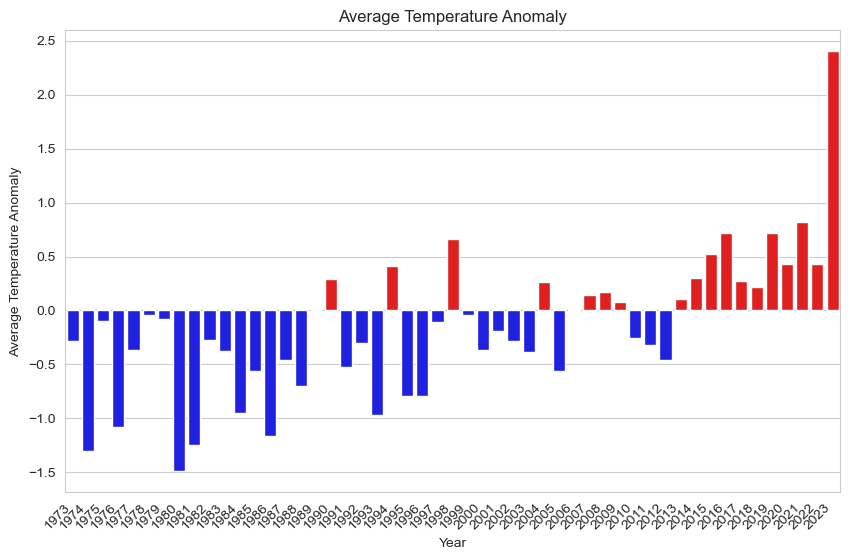

In [11]:
# 온도 편차
df_whole = df[df['year'] > 1972]
df30 = df[(df['year'] >= 1991) & (df['year'] <= 2020)]
tavg30  = df30['avgTa'].mean()

annual_tavg = df_whole.groupby(["year", "station"])["avgTa"].mean().reset_index()
annual_tavg = annual_tavg.groupby('year')['avgTa'].mean()

anomaly_index = annual_tavg - tavg30
anomaly_index_df = anomaly_index.reset_index(name='tavg_anomaly')

anomaly_index_df['color'] = anomaly_index_df['tavg_anomaly'].apply(lambda x: 'red' if x > 0 else 'blue')

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='tavg_anomaly', data=anomaly_index_df, palette=anomaly_index_df['color'])

plt.xlabel("Year")
plt.ylabel("Average Temperature Anomaly")
plt.title("Average Temperature Anomaly")
plt.xticks(rotation=45, ha='right')
plt.show()

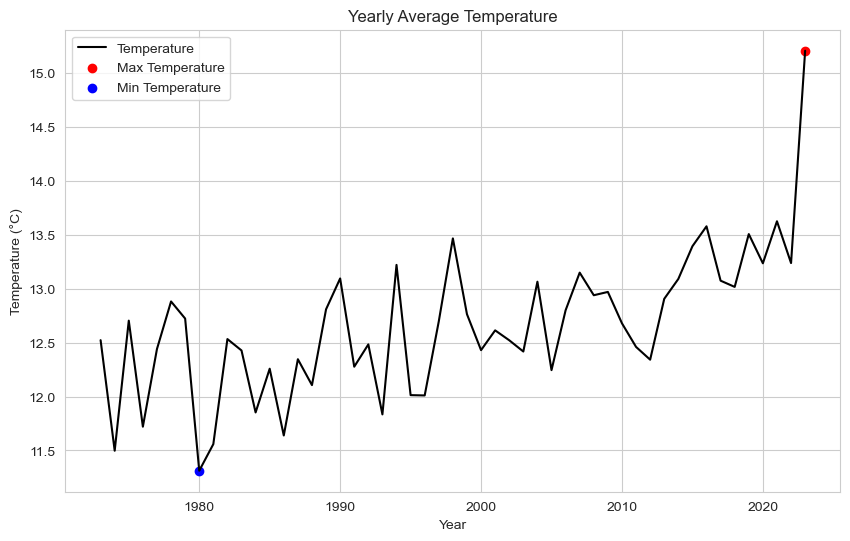

In [12]:
# 일평균기#
tavg = df_whole.groupby('year')['avgTa'].mean().reset_index()
plt.figure(figsize=(10, 6))

sns.lineplot(data=tavg, x='year', y='avgTa', markersize=8, color='black', label='Temperature')

max_temp_year = tavg.loc[tavg['avgTa'].idxmax()]['year']
min_temp_year = tavg.loc[tavg['avgTa'].idxmin()]['year']

plt.scatter(max_temp_year, tavg.loc[tavg['year'] == max_temp_year, 'avgTa'], color='red', label='Max Temperature')
plt.scatter(min_temp_year, tavg.loc[tavg['year'] == min_temp_year, 'avgTa'], color='blue', label='Min Temperature')

plt.title('Yearly Average Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()

plt.show()

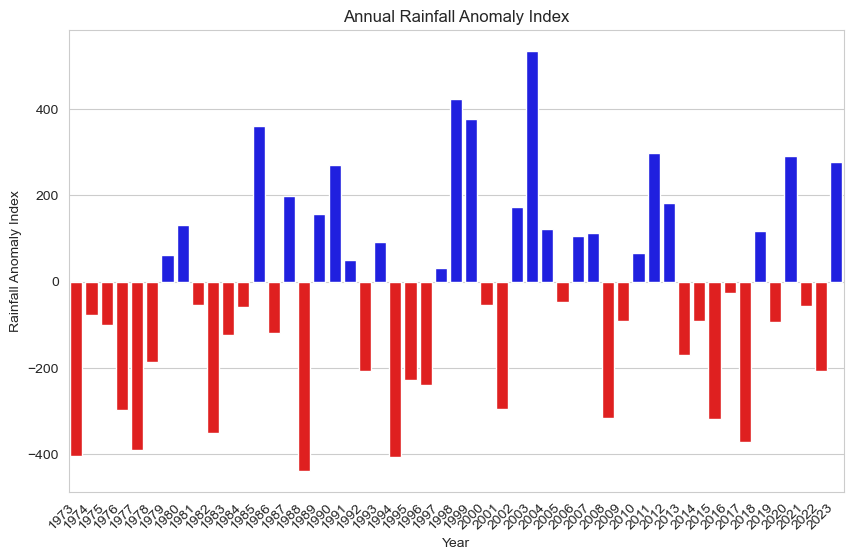

In [13]:
# 강수량 편차
rain30 = df30.groupby(['station', 'year'])['sumRn'].sum().reset_index()
rain30 = rain30['sumRn'].mean()

annual_rainfall = df_whole.groupby(["year", "station"])["sumRn"].sum().reset_index()
annual_rainfall = annual_rainfall.groupby('year')['sumRn'].mean()

mean_rainfall = annual_rainfall.mean()
anomaly_index = annual_rainfall - rain30
anomaly_index_df = anomaly_index.reset_index(name='rainfall_anomaly')

anomaly_index_df['color'] = anomaly_index_df['rainfall_anomaly'].apply(lambda x: 'red' if x < 0 else 'blue')

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='rainfall_anomaly', data=anomaly_index_df, palette=anomaly_index_df['color'])

plt.xlabel("Year")
plt.ylabel("Rainfall Anomaly Index")
plt.title("Annual Rainfall Anomaly Index")
plt.xticks(rotation=45, ha='right')
plt.show()

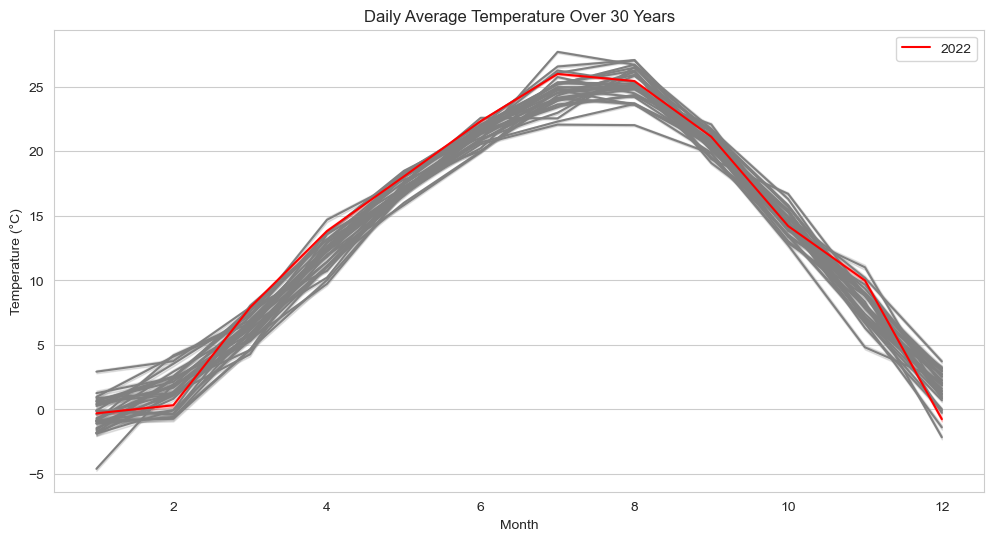

In [14]:
plt.figure(figsize=(12, 6))
for year in range(1991, 2021):
    sns.lineplot(data=df[df['year'] == year], x='month', y='avgTa', color='gray')
sns.lineplot(data=df[df['year'] == 2022], x='month', y='avgTa', color='red', label='2022')

plt.title('Daily Average Temperature Over 30 Years')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(False, axis='x')
plt.legend()
plt.show()

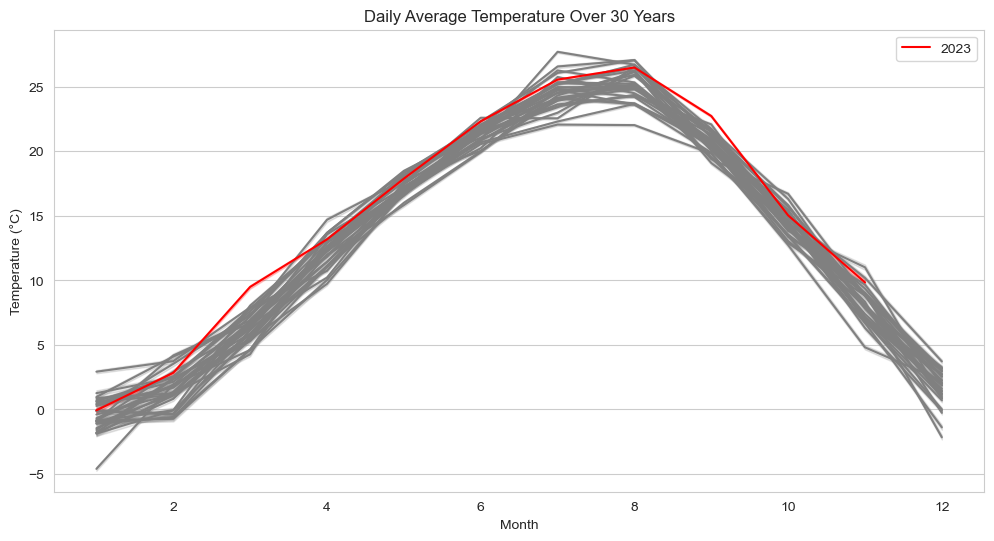

In [15]:
plt.figure(figsize=(12, 6))
for year in range(1991, 2021):
    sns.lineplot(data=df[df['year'] == year], x='month', y='avgTa', color='gray')
sns.lineplot(data=df[df['year'] == 2023], x='month', y='avgTa', color='red', label='2023')

plt.title('Daily Average Temperature Over 30 Years')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(False, axis='x')
plt.legend()
plt.show()

In [16]:
tavg_table(df, 2022)
tavg_table(df, 2023)
rain_table(df, 2022)
rain_table(df, 2023)

In [17]:
norain_station(df, 2022)

,station,month,sumRn
11,강릉,12,0.0
37,거제,2,0.0
48,거창,1,0.0
52,거창,5,0.0
109,고흥,2,0.0
121,광양시,2,0.0
180,김해시,1,0.0
181,김해시,2,0.0
204,남해,1,0.0
205,남해,2,0.0


1월 강수량이 0인 지역: 거창, 김해시, 남해, 대구, 마산, 밀양, 부산, 북창원, 산청, 순천, 안동, 여수, 영천, 의령군, 진주, 청송군, 통영, 함양군, 합천
2월 강수량이 0인 지역: 거제, 고흥, 광양시, 김해시, 남해, 마산, 밀양, 부산, 북창원, 순천, 양산시, 여수, 영천, 진주, 통영, 합천
5월 강수량이 0인 지역: 거창
12월 강수량이 0인 지역: 강릉, 북강릉


In [18]:
minmax_station(df, 2022)

2022년 전국에서 일최고기온을 기록한 지역은 포항으로, 8월 7일, 37.9°C를 기록하였다.
2022년 전국에서 일최저기온을 기록한 지역은 대관령으로, 12월 24일, -21.8°C를 기록하였다.
2022년 전국에서 일최고강수량을 기록한 지역은 포항으로, 9월 6일, 342.4mm를 기록하였다.
2022년 전국에서 일최고최심신적설을 기록한 지역은 광주로, 12월 23일, 32.9cm 기록하였다.


In [19]:
days_rank(df[df['year']!=2023], 2022)

,year,강수여부,순위
49,2022,273.589474,3.0


,year,한파여부,순위
49,2022,7.684211,18.0


,year,폭염여부,순위
49,2022,10.747368,17.0


In [20]:
norain_station(df, 2023)

,station,month,sumRn
672,원주,2,0.0
870,철원,2,0.0


1월 강수량이 0인 지역: 
2월 강수량이 0인 지역: 원주, 철원
5월 강수량이 0인 지역: 
12월 강수량이 0인 지역: 


In [21]:
minmax_station(df, 2023)

2023년 전국에서 일최고기온을 기록한 지역은 강릉으로, 8월 3일, 38.4°C를 기록하였다.
2023년 전국에서 일최저기온을 기록한 지역은 대관령으로, 1월 25일, -25.2°C를 기록하였다.
2023년 전국에서 일최고강수량을 기록한 지역은 군산으로, 7월 14일, 372.8mm를 기록하였다.
2023년 전국에서 일최고최심신적설을 기록한 지역은 울릉도로, 1월 24일, 71.5cm 기록하였다.


In [22]:
days_rank(df, 2023)

,year,강수여부,순위
50,2023,227.526316,50.0


,year,한파여부,순위
50,2023,3.547368,44.0


,year,폭염여부,순위
50,2023,14.0,6.0


In [23]:
def draw_tavg_month(df, year):    
    df30 = df[(df['year'] >= 1991) & (df['year'] <= 2020)]
    dfyear = df[df['year'] == year]
    
    tavg30 = df30.groupby(["month", "station"])["avgTa"].mean().reset_index()
    tavg30 = tavg30.groupby('month')['avgTa'].mean()
    
    tavgyear = dfyear.groupby(["month", "station"])["avgTa"].mean().reset_index()
    tavgyear = tavgyear.groupby('month')['avgTa'].mean()
    
    anomaly_index = tavgyear - tavg30
    anomaly_index_df = anomaly_index.reset_index(name='tavg_anomaly')
    
    anomaly_index_df['color'] = anomaly_index_df['tavg_anomaly'].apply(lambda x: 'red' if x > 0 else 'blue')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='month', y='tavg_anomaly', data=anomaly_index_df, palette=anomaly_index_df['color'])
    
    plt.xlabel("Month")
    plt.ylabel("Temperature Anomaly")
    plt.title(f"{year} Monthly Temperature Anomaly for year")
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [24]:
def draw_rain_month(df, year):    
    df30 = df[(df['year'] >= 1991) & (df['year'] <= 2020)]
    dfyear = df[df['year'] == year]
    
    
    rain30 = df30.groupby(["month", "station", "year"])["sumRn"].sum().reset_index()
    rain30 = rain30.groupby('month')['sumRn'].mean()
    
    rainyear = dfyear.groupby(["month", "station", "year"])["sumRn"].sum().reset_index()
    rainyear = rainyear.groupby('month')['sumRn'].mean()
    
    anomaly_index = rainyear - rain30
    anomaly_index_df = anomaly_index.reset_index(name='rain_anomaly')
    
    anomaly_index_df['color'] = anomaly_index_df['rain_anomaly'].apply(lambda x: 'red' if x < 0 else 'blue')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='month', y='rain_anomaly', data=anomaly_index_df, palette=anomaly_index_df['color'])
    
    plt.xlabel("Month")
    plt.ylabel("Rainfall Anomaly")
    plt.title(f"{year} Monthly Rainfall Anomaly for year")
    plt.xticks(rotation=45, ha='right')
    plt.show()

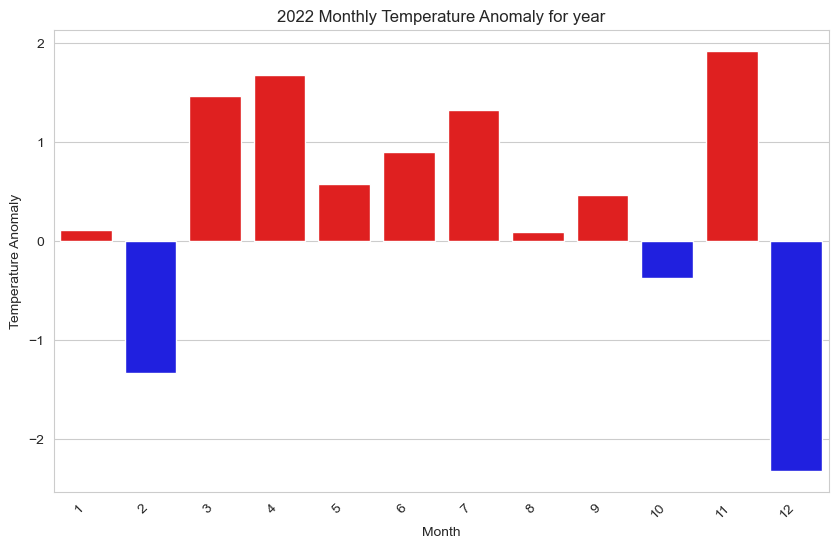

In [25]:
draw_tavg_month(df, 2022)

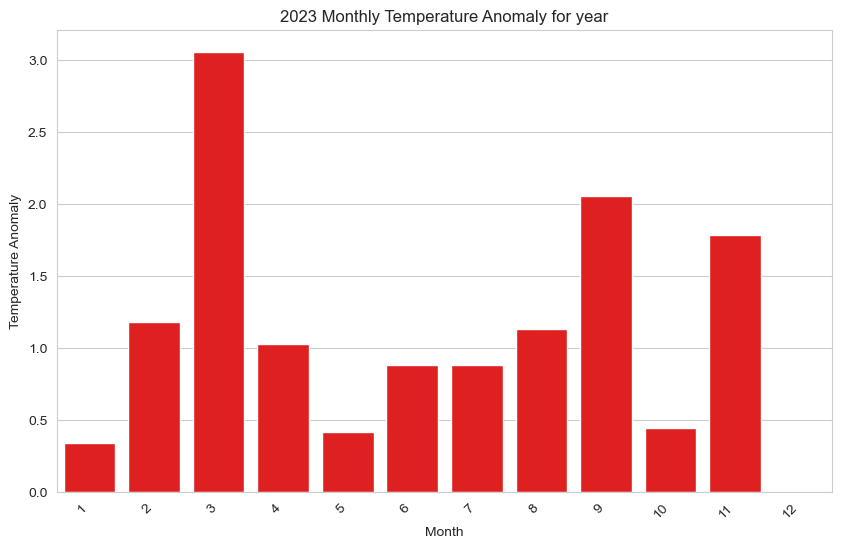

In [26]:
draw_tavg_month(df, 2023)

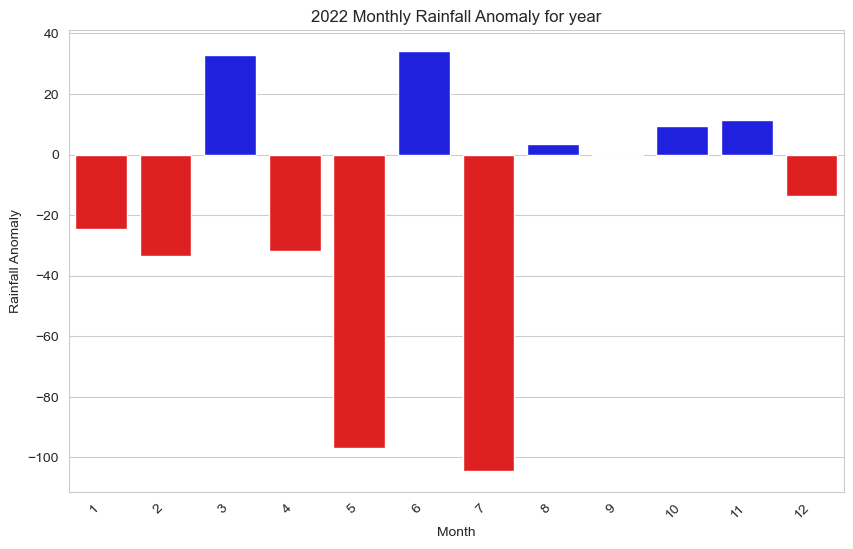

In [27]:
draw_rain_month(df, 2022)

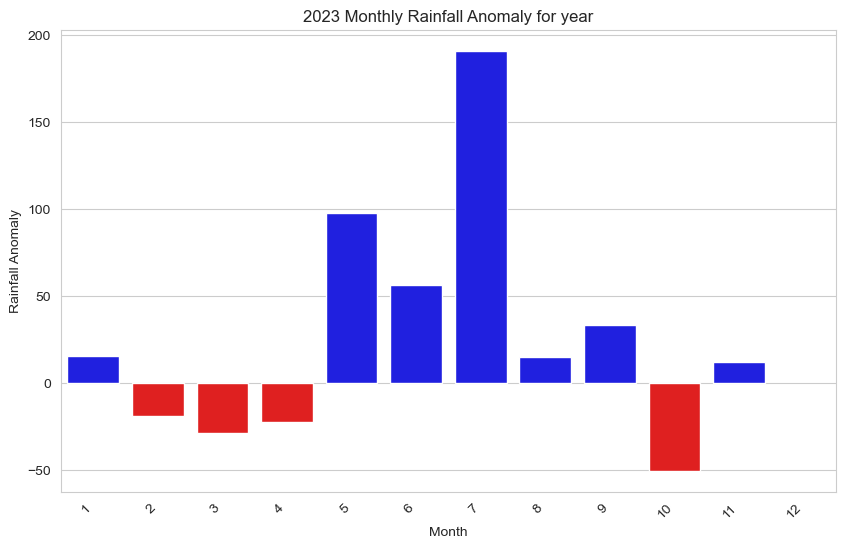

In [28]:
draw_rain_month(df, 2023)

In [52]:
district_filename = '../data/행정구역.csv'
district = pd.read_csv(district_filename, header=1)
district = district[['시도명칭', '시군구명칭']]

In [53]:
district['시군구명칭'] = district['시군구명칭'].apply(lambda x: x.replace("시", "").replace("구", "").replace("군", ""))
district.columns = ['district', 'station']

In [54]:
df_district = pd.merge(df, district, on='station', how='inner')
print('df:', len(df), 'df_district:', len(df_district))

df: 1378542 df_district: 14412441


In [60]:
# df_district = df_district.dropna(subset=['district'])
df_district = pd.concat([df_district, df]).drop_duplicates(keep=False)

array(['청주', '수원', '울진', '서귀포', '성산', '보령', '대구', '북강릉', '부산', '완도', '강릉',
       '진주', '철원', '강화', '문경', '안동', '영주', '홍성', '양평', '산청', '이천', '봉화',
       '영덕', '대관령', '밀양', '청송군', '춘천', '군산', '남해', '동해', '고창', '거제', '부안',
       '부여', '추풍령', '전주', '흑산도', '대전', '여수', '장흥', '해남', '장수', '광주', '포항',
       '목포', '합천', '거창', '홍천', '제천', '북창원', '보은', '순창군', '광양시', '충주',
       '고창군', '울산', '마산', '인제', '영월', '금산', '동두천', '인천', '함양군', '서울',
       '정선군', '영천', '고흥', '태백', '천안', '남원', '속초', '서산', '임실', '정읍', '보성군',
       '통영', '원주', '구미', '의성', '울릉도', '고산', '제주', '창원', '강진군', '상주',
       '북춘천', '백령', '문산', '의령군', '경주시', '김해시', '영광군', '순천', '진도군', '양산시',
       '세종', '파주', '백령도'], dtype=object)